In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
!unzip -qo Parkinson_disease_detection.zip

--2023-04-29 13:07:10--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.175
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8201907 (7.8M) [application/x-zip-compressed]
Saving to: ‘Parkinson_disease_detection.zip’

Parkinson_disease_d 100%[===================>]   7.82M  4.16MB/s    in 1.9s    

2023-04-29 13:07:13 (4.16 MB/s) - ‘Parkinson_disease_detection.zip’ saved [8201907/8201907]



In [3]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1),
      transforms.RandomRotation(degrees=360, expand=False),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.Resize(256),
    ]
)

In [4]:
from torch.utils.data import Dataset
import numpy as np

class SpiralsDataset2(Dataset):
    def __init__(self, path1, path2, transform):
        self.data = np.load(path1)
        self.files = self.data.files
        
        self.X_list = []
        self.y_list = []
        
        for (X, y) in zip(self.data[self.files[0]], self.data[self.files[1]]):
            for _ in range(70):
                self.X_list.append(transform(X))
                self.y_list.append(0 if y == 'healthy' else 1)
                
        self.data = np.load(path2)
        self.files = self.data.files
        
        for (X, y) in zip(self.data[self.files[0]], self.data[self.files[1]]):
            for _ in range(70):
                self.X_list.append(transform(X))
                self.y_list.append(0 if y == 'healthy' else 1)
        
    def __getitem__(self, idx):
        return self.X_list[idx], self.y_list[idx]
    
    def __len__(self):
        return len(self.X_list)

In [5]:
train_data = SpiralsDataset2('/kaggle/working/Parkinson_disease_detection/train_set.npz',
                             '/kaggle/working/Parkinson_disease_detection/test_set.npz',
                             transform)
train_data

In [6]:
len(train_data)

7140

Text(0.5, 1.0, '0')

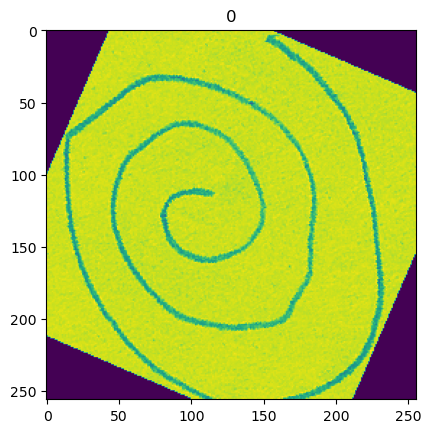

In [7]:
X, y = train_data[1453]
plt.imshow(X.squeeze())
plt.title(y)

In [8]:
train_data, test_data = torch.utils.data.random_split(train_data, [6500, 640])

In [9]:
len(train_data), len(test_data)

(6500, 640)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 20

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x71c4b6a4b810>,
 <torch.utils.data.dataloader.DataLoader at 0x71c4b6a4b7d0>)

In [11]:
print(f"Train: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train: 325 batches of 20
Test: 32 batches of 20


In [12]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(hidden_units, hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(hidden_units, hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Dropout(0.5),
            nn.Linear(hidden_units*64*64,
                     output_shape)
        )
        
    def forward(self, X):
        X = self.conv_block_1(X)
        #print(X.shape)
        X = self.conv_block_2(X)
        #print(X.shape)
        return self.classifier(X)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
cnn_model = CNNModel(1, 15, 2).to(device)
cnn_model

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=61440, out_features=2, bias=True)
  )
)

In [15]:
import requests
from pathlib import Path

# so we dumb, we using helper functions
# we can ALSO just use torchmetrics functions for accuracy
# download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_model.parameters(),
                            lr=0.001)

In [17]:
def train_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device):
    
    train_loss = 0
    train_acc = 0
    model.to(device)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_preds.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}%")

In [18]:
def test_loop(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            test_preds = model(X)
            test_loss += loss_fn(test_preds.squeeze(), y)
            test_acc += accuracy_fn(y_true=y,
                                   y_pred=test_preds.argmax(dim=1))
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}%")

In [19]:
cnn_model.to(device)
test = torch.rand(20,1,256,256)
cnn_model(test.to(device))

tensor([[ 0.1203, -0.2334],
        [-0.0415, -0.1529],
        [ 0.1021,  0.5124],
        [ 0.4738,  0.0649],
        [-0.0750, -0.2469],
        [ 0.2075,  0.4378],
        [ 0.2118,  0.0573],
        [ 0.0976, -0.1410],
        [-0.0326, -0.0349],
        [ 0.5058,  0.1640],
        [ 0.1430,  0.6118],
        [ 0.2277, -0.1172],
        [ 0.3532,  0.2664],
        [ 0.5018, -0.2884],
        [ 0.1828, -0.3313],
        [ 0.1362, -0.2159],
        [ 0.3359,  0.0722],
        [ 0.1664, -0.1090],
        [ 0.6388, -0.0923],
        [ 0.3836, -0.4885]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n ----------")
    train_loop(cnn_model,
              train_dataloader,
              loss_fn,
              optimizer,
              accuracy_fn,
              device)
    test_loop(cnn_model,
             test_dataloader,
             loss_fn,
             accuracy_fn,
             device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ----------
Train loss: 0.69221 | Train acc: 75.13846%
Test loss: 0.44450 | Test acc: 81.25000%
Epoch: 1
 ----------
Train loss: 0.29425 | Train acc: 88.03077%
Test loss: 5.39341 | Test acc: 50.46875%
Epoch: 2
 ----------
Train loss: 0.19336 | Train acc: 92.46154%
Test loss: 0.84393 | Test acc: 75.62500%


In [21]:
model = nn.Sequential(
    cnn_model,
    nn.Softmax()
)

In [22]:
torch.save(model, 'spirals_model.pth')

In [23]:
model = torch.load('/kaggle/input/spirals-model/spirals_model.pth', map_location=torch.device('cpu'))
model

Sequential(
  (0): CNNModel(
    (conv_block_1): Sequential(
      (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block_2): Sequential(
      (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=61440, out_features=2, bias=True)
    )
  )
  (1): Softmax(dim=None)
)

In [24]:
model.to(device)

Sequential(
  (0): CNNModel(
    (conv_block_1): Sequential(
      (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block_2): Sequential(
      (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=61440, out_features=2, bias=True)
    )
  )
  (1): Softmax(dim=None)
)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0.5, 1.0, "tensor([[0.0094, 0.9906]], device='cuda:0', grad_fn=<SoftmaxBackward0>)")

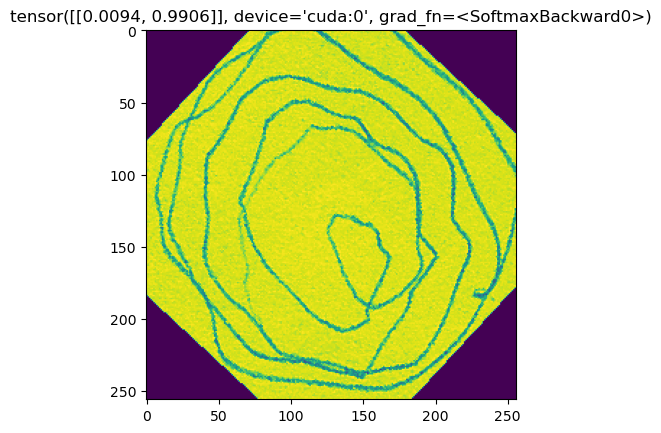

In [25]:
from PIL import Image

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=360, expand=False),
    transforms.Resize(256)
]) 

img = Image.open('/kaggle/working/Parkinson_disease_detection/test_image_parkinson.png')
img = img_transform(img)
plt.imshow(img.squeeze())

output = model(img.unsqueeze(dim=0).to(device))
plt.title(output)

Text(0.5, 1.0, "tensor([[9.9999e-01, 1.3088e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)")

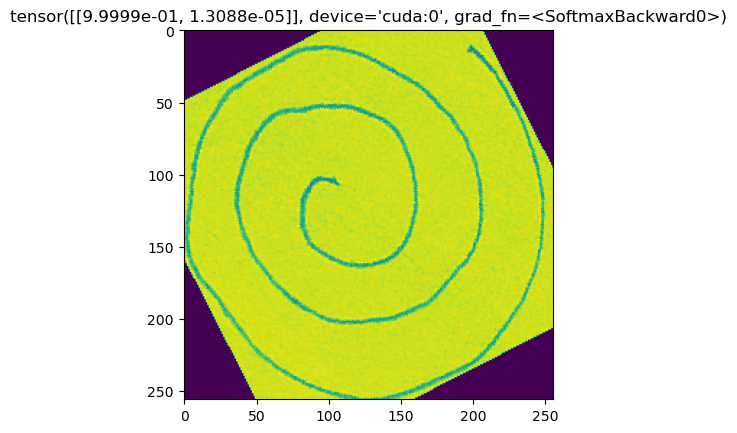

In [26]:
img = Image.open('/kaggle/working/Parkinson_disease_detection/test_image_healthy.png')
img = img_transform(img)
plt.imshow(img.squeeze())

output = model(img.unsqueeze(dim=0).to(device))
plt.title(output)